In [172]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt
%matplotlib inline

In [23]:
data = pd.read_csv('forestfires.csv')

In [24]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [25]:
data['month'] = [mth in {'jun', 'jul', 'aug'} for mth in data['month']]
data['month'] = data['month'].map(int)
data.drop(['day'], axis=1, inplace=True)

In [124]:
X = data[data.columns[:-1]]
X = (X - X.mean(axis=0)) / X.std(axis=0)  # Scaling the data
X['const'] = [1] * len(X)
y = data['area']

In [141]:
X.head()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,const
0,1.007337,0.569309,-0.904895,-0.805180,-1.322045,-1.828706,-0.860113,-1.840857,0.411326,1.497164,-0.073197,1
1,1.007337,-0.243765,-0.904895,-0.008094,-1.178399,0.488418,-0.509195,-0.153130,-0.691786,-1.740070,-0.073197,1
2,1.007337,-0.243765,-0.904895,-0.008094,-1.048806,0.560173,-0.509195,-0.738668,-0.691786,-1.516813,-0.073197,1
3,1.439531,1.382383,-0.904895,0.191177,-1.211188,-1.896429,-0.004751,-1.823636,3.230391,-0.009824,0.602572,1
4,1.439531,1.382383,-0.904895,-0.243597,-0.930142,-1.796859,0.126843,-1.289763,3.352959,-1.237741,-0.073197,1


In [142]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [178]:
def fit(X, y):
    X = np.matrix(X)
    y = np.array(y)
    return (X.T.dot(X)).I.dot(X.T).dot(y)

def predict(coef, X):
    return np.matrix(X).dot(np.array(coef).T)

def mse(y1, y2):
    return ((np.array(y1) - np.array(y2))**2).mean()

def transform(y, c):
    return np.log(y + c)

def transform_back(y, c):
    return np.exp(y) - c

Обучим модель и применим к тестовым данным

In [180]:
coef = fit(X_train, y_train)
res = predict(coef, X_test)
mse(res, y_test)

4124.1561387288557

Ошибка: 4124

Попробуем преобразовать целевую переменную по правилу log(y + c)

In [168]:
C = np.logspace(-3, 3, 100)
errors1 = []
errors2 = []
for c in C:
    coef = fit(X_train, transform(y_train, c))
    res = predict(coef, X_test)
    
    errors1.append(mse(res, transform(y_test, c)))
    errors2.append(mse(transform_back(res, c), y_test))

In [169]:
C[np.argmin(errors1)]

1000.0

In [170]:
C[np.argmin(errors2)]

53.366992312063125

In [171]:
np.min(errors2)

4014.7535018749068

В первом случае(errors1) чем больше c тем меньше ошибка, но этот результат обманчив. При больших c преобразование становится константным (столбец с константным значением ln(c)). Во втором случае можно взять с порядка 50. Но ошибку это не сильно уменьшает (стало 4015, было 4124)

Посмотрим насколько меняется результат при различных разбиениях

In [183]:
errors = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=i)
    coef = fit(X_train, transform(y_train, 50))
    res = predict(coef, X_test)
    errors.append(mse(transform_back(res, 50), y_test))

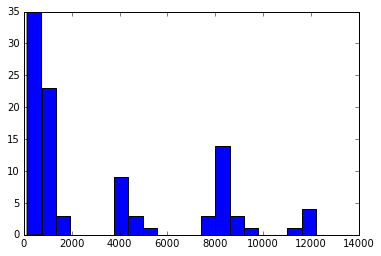

In [188]:
plt.hist(errors, bins = 20)
plt.show()

In [192]:
print np.mean(errors)
print np.std(errors)

3343.20381605
3631.43473737


Видно что результат меняется очень сильно. Среднее отклонение тогоже порядка что и сама величина. Модель никуда не годится.

In [199]:
from sklearn.ensemble import GradientBoostingRegressor

In [212]:
model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [213]:
res = model.predict(X_test)
mse(res, y_test)

2571.6798424203348